### **Content License Agreement**

<font color='red'><b>**WARNING**</b></font> : 본 자료는 삼성 청년 SW아카데미의 컨텐츠 자산으로, 보안서약서에 의거하여 어떠한 사유로도 임의로 복사, 촬영, 녹음, 복제, 보관, 전송하거나 허가 받지 않은 저장매체를 이용한 보관, 제3자에게 누설, 공개 또는 사용하는 등의 무단 사용 및 불법 배포 시 법적 조치를 받을 수 있습니다.

# **Objectives**

1. 실습 개요
    - RAG (Retrieval-Augmented Generation)의 개념을 이해하고 활용법을 학습.
    - Upstage의 Solar LLM을 기반으로 단계별 RAG 시스템을 구축.
    - RAG 시스템 설계와 구현을 통해 언어 모델의 응용 능력 강화.

2. 실습 진행 목적 및 배경
    - 목적: RAG 개념과 Solar LLM을 활용하여 정보 검색과 언어 생성을 결합한 실무형 시스템 구현 역량을 강화합니다.
    - 배경: RAG는 언어 모델과 정보 검색 기술의 융합으로 복잡한 문제 해결에 활용되며, 실제 실무에서 많이 활용됩니다. 이를 통해, 실제 실무에서 적용할 수 있는 역량을 강화합니다.

3. 실습 수행으로 얻어갈 수 있는 역량
    - RAG 개념을 이해하고 이를 실제로 구현하는 능력.
    - LangChain을 활용한 LLM Chain 설계 및 챗봇 개발 기술.

4. 실습 핵심 내용
    - LLM Chain 구현: LangChain을 활용하여 간단한 ChatBot을 설계하고 구현.
    - RAG 시스템 구축: RAG의 개념을 이해하고 이를 단계적으로 설계 및 구현.
    - LLM API 활용: Upstage의 Solar LLM API를 통해 LLM을 호출하고 시스템에 통합.
    - 실무 프로젝트 기반 학습: 실질적인 프로젝트 설계를 통해 실무 적용 가능성 향상.   

⭐ 이번에는 여러분들만의 서비스 기획안에 따라 데이터를 바꾸어 진행해보세요. 본 실습은 프로젝트 예시로 작성된 제품 매뉴얼 문서를 기반으로 진행됩니다.

# **Prerequisties**

```
langchain == 0.3.12
langchain-chroma == 0.1.4
langchain-core == 0.3.25
langchain-openai == 0.2.12
langchain-text-splitters == 0.3.3
langchain-upstage == 0.4.0
getpass4 == 0.0.14.1
openai == 1.57.4
ragas == 0.2.8
langchain_community == 0.3.12
```



In [ ]:
# 약 1분 소요
!pip install -qU openai langchain langchain-upstage langchain-chroma getpass4 ragas

#### RAGAS callback 함수 수정
- 경로: `/usr/local/lib/python3.10/dist-packages/ragas/callbacks.py`
- ragas를 다운로드 받고, 위 파일 경로의 값을 아래 코드로 바꿔끼웁니다.
- 실행한 후 세션을 다시 시작합니다. 세션을 다시 시작한 후 아래 set API key부터 실행합니다.

```
from __future__ import annotations

import json
import typing as t
import uuid
from dataclasses import dataclass, field
from enum import Enum

from langchain_core.callbacks import (
    BaseCallbackHandler,
    CallbackManager,
    CallbackManagerForChainGroup,
    CallbackManagerForChainRun,
    Callbacks,
)
from pydantic import BaseModel, Field


def new_group(
    name: str,
    inputs: t.Dict,
    callbacks: Callbacks,
    tags: t.Optional[t.List[str]] = None,
    metadata: t.Optional[t.Dict[str, t.Any]] = None,
) -> t.Tuple[CallbackManagerForChainRun, CallbackManagerForChainGroup]:
    tags = tags or []
    metadata = metadata or {}

    # start evaluation chain
    if isinstance(callbacks, list):
        cm = CallbackManager.configure(inheritable_callbacks=callbacks)
    else:
        cm = t.cast(CallbackManager, callbacks)
    cm.tags = tags
    cm.metadata = metadata
    rm = cm.on_chain_start({"name": name}, inputs)
    child_cm = rm.get_child()
    group_cm = CallbackManagerForChainGroup(
        child_cm.handlers,
        child_cm.inheritable_handlers,
        child_cm.parent_run_id,
        parent_run_manager=rm,
        tags=child_cm.tags,
        inheritable_tags=child_cm.inheritable_tags,
        metadata=child_cm.metadata,
        inheritable_metadata=child_cm.inheritable_metadata,
    )

    return rm, group_cm


class ChainType(Enum):
    EVALUATION = "evaluation"
    METRIC = "metric"
    ROW = "row"
    RAGAS_PROMPT = "ragas_prompt"


class ChainRun(BaseModel):
    run_id: str
    parent_run_id: t.Optional[str]
    name: str
    inputs: t.Dict[str, t.Any]
    metadata: t.Dict[str, t.Any]
    outputs: t.Dict[str, t.Any] = Field(default_factory=dict)
    children: t.List[str] = Field(default_factory=list)


class ChainRunEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, uuid.UUID):
            return str(o)
        if isinstance(o, ChainType):
            return o.value
        # if isinstance(o, EvaluationResult):
        #     return ""
        return json.JSONEncoder.default(self, o)


@dataclass
class RagasTracer(BaseCallbackHandler):
    traces: t.Dict[str, ChainRun] = field(default_factory=dict)

    def on_chain_start(
        self,
        serialized: t.Dict[str, t.Any],
        inputs: t.Dict[str, t.Any],
        *,
        run_id: uuid.UUID,
        parent_run_id: t.Optional[uuid.UUID] = None,
        tags: t.Optional[t.List[str]] = None,
        metadata: t.Optional[t.Dict[str, t.Any]] = None,
        **kwargs: t.Any,
    ) -> t.Any:
        self.traces[str(run_id)] = ChainRun(
            run_id=str(run_id),
            parent_run_id=str(parent_run_id) if parent_run_id else None,
            name=serialized["name"],
            inputs=inputs,
            metadata=metadata or {},
            children=[],
        )

        if parent_run_id and str(parent_run_id) in self.traces:
            self.traces[str(parent_run_id)].children.append(str(run_id))

    def on_chain_end(
        self,
        outputs: t.Dict[str, t.Any],
        *,
        run_id: uuid.UUID,
        **kwargs: t.Any,
    ) -> t.Any:
        self.traces[str(run_id)].outputs = outputs

    def to_jsons(self) -> str:
        return json.dumps(
            [t.model_dump() for t in self.traces.values()],
            cls=ChainRunEncoder,
        )


@dataclass
class MetricTrace(dict):
    scores: t.Dict[str, float] = field(default_factory=dict)

    def __repr__(self):
        return self.scores.__repr__()

    def __str__(self):
        return self.__repr__()


def parse_run_traces(
    traces: t.Dict[str, ChainRun],
    parent_run_id: t.Optional[str] = None,
) -> t.List[t.Dict[str, t.Any]]:

    root_traces = [
        chain_trace
        for chain_trace in traces.values()
        if chain_trace.parent_run_id == parent_run_id
    ]

    if len(root_traces) > 1:
        raise ValueError(
            "Multiple root traces found! This is a bug on our end, please file an issue and we will fix it ASAP :)"
        )
    root_trace = root_traces[0]

    # get all the row traces
    parased_traces = []
    for row_uuid in root_trace.children:
        row_trace = traces[row_uuid]
        metric_traces = MetricTrace()
        for metric_uuid in row_trace.children:
            metric_trace = traces[metric_uuid]
            metric_traces.scores[metric_trace.name] = metric_trace.outputs.get(
                "output", {}
            )
            # get all the prompt IO from the metric trace
            prompt_traces = {}
            for i, prompt_uuid in enumerate(metric_trace.children):
                prompt_trace = traces[prompt_uuid]
                output = prompt_trace.outputs.get("output", {})
                output = output[0] if isinstance(output, list) else output
                prompt_traces[f"{prompt_trace.name}"] = {
                    "input": prompt_trace.inputs.get("data", {}),
                    "output": output,
                }
            metric_traces[f"{metric_trace.name}"] = prompt_traces
        parased_traces.append(metric_traces)

    return parased_traces

```

#### set API key

In [ ]:
import os
import getpass
import warnings

warnings.filterwarnings("ignore")

# Get the Upstage API key using getpass
try:
    if "UPSTAGE_API_KEY" not in os.environ or not os.environ["UPSTAGE_API_KEY"]:
        os.environ["UPSTAGE_API_KEY"] = getpass.getpass("Enter your Upstage API key: ")

    print("API key has been set successfully.")

except:
    print("Something wrong with your API KEY. Check your API Console again.")

Enter your Upstage API key: ··········
API key has been set successfully.


# **Exercise Overview**
## **실습 목차**
-  **RAG 파이프라인 단계별 기법 소개**:  RAG 개념을 이해하고 단계별로 RAG를 직접 구현해보자<br>
    - 1-1 What is RAG?
    - 1-2 단계별 RAG 구현해보기
      - 1-2-1 문서 전처리 (Document Preprocessing) <br>
        (1) Loading Documents by `Upstage Document Parse API` <br>
        (2) Text Splitting <br>
        (3) Text Embedding  by `Upstage Solar Embedding API` <br>
        (4) Vectorstore <br>
      - 1-2-2 RAG 실행하기  <br>
       (1) Retrieving Related Chunks from the Vectorstore <br>
       (2) Creating a Prompt with Retrieved Results <br>
       (3) Implementing an LLM Chain <br>
       (4) Executing the LLM Chain and Generating the Response
    - 1-3 Web에서 데이터 가져와서 RAG 구축 연습해보기
    - 1-4 Open Source Tool(RAGAS)를 사용한 RAG Evaluation

## 1-1 What is RAG

![Overview](https://drive.google.com/uc?id=18nYSFhTdlhmlXGEaiENEzfJL9N6v23XI)


### 📘  RAG 란?

- 정의 :  RAG(Retrieval-Augmented Generation)는 **검색 엔진**과 **LLM(대규모 언어 모델)**을 결합한 기술로, 주어진 쿼리에 대해 정보를 검색하고 검색된 정보를 활용하여 LLM이 더 정확하고 맥락에 맞는 응답을 생성할 수 있도록 도와줍니다.
- 방식
  - 이 기술은 LLM이 보유하지 않는 정보를 보충하기 위해 외부 문서를 검색하여 이를 기반으로 응답을 생성합니다.
  - 더 구체적으로는 외부 문서를 로드하고, 전처리 단계를 통해서 이를 조각(chunks)으로 분리한 후, 쿼리와 관련된 조각을 가져와 LLM 프롬프트에 포함하는 방식으로 외부 정보를 LLM에게 제공한 후, LLM이 응답을 생성합니다.
- 기대효과 : LLM이 자체적으로 보유하지 않는 정보를 외부 문서를 통해 보충해주기에, LLM의 한계인 Hallucination과 Knowledge Cutoff 문제를 해결할 수 있습니다.




## 1-2 단계별 RAG 구현해보기

### 📘 각 단계별 설명

<img src="https://drive.google.com/uc?id=1hwyxaRToKo7JbaupBctR0KIKOgz3jOsm" alt="Definition of DP" width="800" />

1. **문서 전처리 (Document Preprocessing)**:
   1. **문서 로드 (Loading Documents)**: `Upstage Document Parse API`를 사용해 외부 PDF 문서를 HTML 텍스트 데이터 형태로 로드합니다.
   2. **텍스트 분할 (Text Splitting)**: 긴 문서를 작은 조각(chunks)으로 분할하여 검색 효율성을 높입니다. 이를 통해 모델이 보다 구체적이고 정확하게 정보를 찾을 수 있습니다.
   3.  **임베딩 (Embedding)**: `Upstage Solar Embedding API`를 사용해 텍스트를 벡터로 변환합니다. 이 작업은 문서의 의미/문맥을 벡터 공간에 매핑하여 모델이 이를 검색 및 분석에 활용할 수 있도록 합니다.
   4. **벡터스토어 (Vectorstore)**: 임베딩된 벡터를 저장하는 데이터베이스로, RAG 시스템 내에서 검색할 수 있는 공간을 제공합니다.

2. **RAG 실행 (Implementing RAG)**:
   5. **관련 조각 검색 (Retrieving Related Chunks)**: 벡터 스토어에서 쿼리와 관련된 조각을 검색해 가져옵니다. 이를 통해 LLM이 응답을 생성할 때 필요한 정보를 제공합니다.
   6. **프롬프트 생성 (Creating a Prompt with Retrieved Results)**: 검색된 조각을 프롬프트에 포함시켜 LLM이 문맥을 이해하고 응답할 수 있도록 합니다.
   7. **LLM 체인 구현 (Implementing an LLM Chain)**: 위의 입력 프롬프트를 기반으로 LLM 체인을 정의합니다.
   8. **LLM 체인 실행 및 응답 출력 (Executing the LLM Chain and Generating the Response)**: LLM 체인을 실행하여 최종 응답을 생성합니다.


### 1-2-1 문서 전처리 (Docuemnt Preprocessing)

#### (1) Loading Documents by `Upstage Document Parse API`

`Upstage Document Parse API`를 사용해 외부 PDF 문서를 HTML 텍스트 데이터 형태로 로드합니다.

- Upstage Document Parse extracts layouts, tables, and figures from any document
- LangChain provides powerful tools for text splitting and vectorization

<img src="https://drive.google.com/uc?id=1vw9GqpzZDrAAfNdUL_ko7-VvJlRZSDou" alt="Definition of DP" width="600" />

**정의**
- `Upstage Document Parse`는 복잡한 문서를 LLM이 이해할 수 있는 형식으로 변환해주는 도구
- LLM은 질의응답 시스템(QA), 문서 요약 등의 자연어 task에는 유용하지만, 문서 파일을 바로 읽고 처리할 수는 없습니다.

**작동 방식**
- 문서 파일을 HTML이나 Markdown과 같은 LLM이 이해할 수 있는 형식으로 변환합니다.
- 문서의 레이아웃, 표 형식, 이미지 등 다양한 요소들을 모두 반영하여 변환을 진행합니다.

<img src="https://drive.google.com/uc?id=1yAbnaXDI6t_wTTV1i03GDqqoanN24bDv" alt="DP" width="600" />

**성능**

<img src="https://drive.google.com/uc?id=1PfgSNDsWr8RgBua7fO5eIDsq43B_W2QH" alt="Definition of DP" width="600" />

In [ ]:
# 실습을 진행할 파일은 Galaxy A12 매뉴얼 문서입니다.
!wget -O galaxy_A12.pdf https://files.customersaas.com/files/AOVV-atOIDUSB5NELiKGDtk8.pdf

# 실제로 진행할 파일은 아래 방식으로 로드하여 진행합니다.

##### 📁 다운로드 된 파일 확인하는 방법

1. Colab 화면 왼쪽 파일 이모지를 클릭해보면 아래 그림처럼 galaxy_A12.pdf가 잘 다운로드 된 것을 확인할 수 있습니다.

2. 만약 위 과정을 실패하셨거나 다른 PDF 문서를 직접 업로드 후 확인해보고 싶으시다면, 상단의 첫 번째 버튼 클릭 후 가능합니다.

- [Galaxy_A12 메뉴얼 PDF 링크](https://files.customersaas.com/files/AOVV-atOIDUSB5NELiKGDtk8.pdf) 에서 로컬에 직접 다운로드 받으신 후 업로드

<img src="https://drive.google.com/uc?id=1p3PoZW4r_v_dpNsSypZYJU-Lp0dlaJdk" alt="Colab File Emoji" width="400" />



In [ ]:
# Document Parse로 다운로드 된 문서 불러오기
%%time

from langchain_upstage import UpstageDocumentParseLoader

layzer = UpstageDocumentParseLoader(
    "galaxy_A12.pdf", # 불러올 파일
    output_format='html',  # 결과물 형태 : HTML
    coordinates= False) # 이미지 OCR 좌표계 가지고 오지 않기

docs = layzer.load()

# layzer.lazy_load()
# 메모리 효율을 향상시키기 위해서, lazy_load() 로 페이지별로 문서를 불러올 수도 있음

In [ ]:
# HTML 형태 확인해보기
for doc in docs:
    print(doc.page_content[:200])

<p id='0' data-category='paragraph' style='font-size:14px'>User manual</p><br><figure><img id='1' alt="" data-coord="top-left:(870,892); bottom-right:(1219,1634)" /></figure><br><h1 id='2' style='font


In [ ]:
# 불러온 HTML 텍스트 데이터를 이미지 형태로 확인해보기
from IPython.display import display, HTML

display(HTML(docs[0].page_content[:2000]))

#### (2) Text Splitting



**📘Text Splitting을 하는 이유**
- 만약, 문서가 길지 않고 짧다면 그대로 넣어주도 무방함.
- 하지만, 문서의 사이즈가 큰 경우
  - LLM에게 입력할 수 있는 최대 토큰 수를 초과
  - 쿼리와 연관되지 않은 불필요한 부분이 포함되어 헷갈리게 함으로써 성능이 잘 나오지 않음.
- 따라서  긴 문서를 작은 조각(chunks)으로 분할하여 검색 효율성을 높입니다. 이를 통해 모델이 보다 구체적이고 정확하게 정보를 찾을 수 있습니다.

<b>📘RecursiveCharacterTextSplitter </b>
- 가장 대표적으로 많이 활용되는 Text Splitter
- **방식**
  - `RecursiveCharacterTextSplitter` : 글자수가 `chunk size`를 넘지 않을 때까지 아래와 같이 text를 분리함.
  -  `(['\n\n', '\n', ' ', ''])` : 문단, 문장, 단어 순서로 문서를 분리하다가 chunk 내 글자수가 `chunk size` 보다 작아지면 분리함.
- **파라미터**
  - `chunk_size` : 하나의 chunk 당 최대 글자 수
  - `chunk_overlap` : 각 chunk 마다 겹치는 글자 수
    - chunk 마다 일부 내용을 겹쳐서 분할된 chuck 마다 맥락이 이어질수 있도록 하기 위함.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
# 2. Split
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100)

splits = text_splitter.split_documents(docs)

print("Splits:", len(splits))

Splits: 271


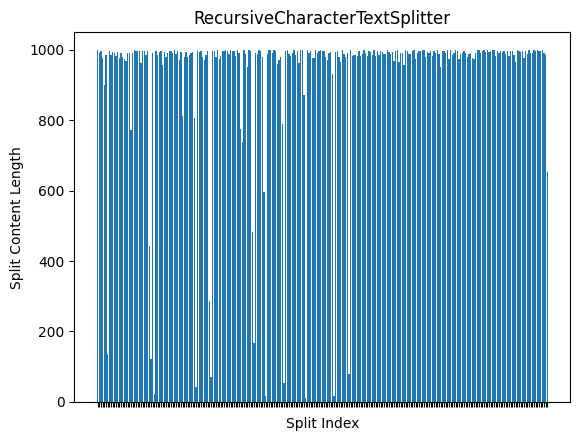

In [ ]:
# split된 결과 확인 : chunk size 1000로 대다수가 분리됨.

import matplotlib.pyplot as plt

split_lengths = [len(split.page_content) for split in splits]

# Create a bar graph
plt.bar(range(len(split_lengths)), split_lengths)
plt.title("RecursiveCharacterTextSplitter")
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.xticks(range(len(split_lengths)), [])
plt.show()

#### (3) Embedding

<img src="https://drive.google.com/uc?id=1dcmr0Q572fBwY-o4GN5mhCCise8WdN7C" alt="solar embedding" width="600" />

**Embedding 정의**
- Embedding은 **자연어(텍스트) 데이터**를 컴퓨터가 이해할 수 있는 **숫자** 형식으로 변환하는 것.
- 사람이 이해하는 텍스트 정보를 컴퓨터가 이해할 수 있는 형식(=Vector)으로 변환하여 데이터를 LLM 등 모델에 쉽게 전달할 수 있도록 합니다.

**`Upstage Solar Embedding API`**

<img src="https://drive.google.com/uc?id=18tPtT8_6M9ilT7q5FkBx9DGYMHj8yRIl" alt="solar embedding" width="600" />

- 성능 : 한국어/영어/일본어 모두 널리 사용되는 임베딩 모델보다 성능이 뛰어남

**RAG에서 Embedding은 VectorStore 에서 모델을 지정하여 활용할 수 있습니다**


#### (4) 벡터스토어 (VectorStore)



**벡터**를 저장하는 데이터베이스로, RAG 시스템 내에서 검색할 수 있는 공간을 제공합니다.
- VectorStore마다 지원하는 검색 알고리즘이 달라짐.
- Vectorstore 유형
  -  로컬 : 내 컴퓨터에 저장
  -  Cloud : 각 DB 회사 서버에 저장
- Langchain이 제공하는 더 다양한 VectorStore : [링크](https://python.langchain.com/v0.2/docs/integrations/vectorstores/)

**ChromaDB**
- Cloud 기반 오픈소스 벡터 데이터베이스
- 임베딩 Vector 저장 및 검색 기능
- 문서 추가 및 업데이트, 삭제
- 다양한 검색 기능 제공
- Langchain과 통합되어 제공

In [ ]:
%%time
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain.docstore.document import Document

# 3. Embed & indexing
vectorstore = Chroma.from_documents(
     documents= splits, embedding=UpstageEmbeddings(model="solar-embedding-1-large")
)

CPU times: user 11.7 s, sys: 184 ms, total: 11.9 s
Wall time: 46.5 s


**참고**
- [Chroma LangChain Documentation](https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/)
- [Chroma Official Documentation](https://docs.trychroma.com/getting-started)

###(Recap.)  OVERVIEW OF RAG

- 외부 문서를 바탕으로 문서 전처리까지 완료
- 이제 각 chunk 단위로 분리된 문서 중 "사용자의 질문(쿼리)"와 관련한 chunk를 **검색**해보자 !

![Overview](https://drive.google.com/uc?id=18nYSFhTdlhmlXGEaiENEzfJL9N6v23XI)




### 1-2-2 RAG 실행하기

#### (5) Retrieving Related Chunks

- 벡터스토어에서 사용자의 질문(쿼리)와 유사한 문서를 검색하는 과정입니다. LLM이 응답을 생성할 때 필요한 정보를 제공합니다.

- Retriever 유형
  - **Sparse Retriever**: 키워드 검색
    - 쿼리를 키워드 벡터로 전환하여 키워드 기반 검색을 진행합니다.
    - 특정 도메인 지식(e.g. 의학, 법률) 등을 검색할 때 용이합니다.
    - 단어들이 직접적으로 유사한 상황에 용이합니다.
    - 대표 알고리즘 : TF-IDF, BM25
  - **Dense Retriever**: 의미 검색
    - 쿼리를 벡터로 임베딩하여 가장 유사도가 높은 chunk를 찾습니다.
    - 복잡한 자연어 질문에 대한 검색 시 용이합니다.
    - 문맥적 유사도가 중요한 상황에 용이합니다.
    - 대표 알고리즘 : FAISS

**참고** <br>
- [Lanchain - Retriever](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/)  documentation을 통해 더 자세한 내용 참고 바랍니다
- [MMR 알고리즘](https://wikidocs.net/231585) 에 대한 설명


In [ ]:
# 사용자의 질문, 쿼리
query = "Please tell me about galaxy a12"

# Dense Retriever 생성
retriever = vectorstore.as_retriever(
    search_type= 'mmr', # default : similarity(유사도) / mmr 알고리즘
    search_kwargs={"k": 3} # 쿼리와 관련된 chunk를 3개 검색하기 (default : 4)
)

result_docs = retriever.invoke(query) # 쿼리 호출하여 retriever로 검색

print(len(result_docs))
print(result_docs[0].page_content[:100])

3
dexterity | Advanced settings | Installed services | About Accessibility</p><br><h1 id='29' style='f


#### (6) Creating a Prompt with Retrieved Results
- 검색된 문서 chunk들을 프롬프트에 포함시켜 LLM이 문맥을 이해하고 응답할 수 있도록 합니다.

In [ ]:
# context에 검색된 chunk들을 넣어줍니다.
# (지난 시간에 배웠던) LLM Chain 구성하는 법.
# 1. llm 정의, 2. prompt 정의, 3. chain 정의, 4. chain 호출

from langchain_upstage import ChatUpstage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatUpstage()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question considering the history of the conversation.
            If you don't know the answer, just say that you don't know.
            ---
            CONTEXT:
            {context}
            """,
        ),
        ("human", "{input}"),
    ]
)

#### (7) Implementing an LLM Chain
- 위의 입력 프롬프트를 기반으로 LLM 체인을 정의합니다.


In [ ]:
chain = prompt | llm | StrOutputParser()

#### (8) Executing the LLM Chain and Generating the Response
-  LLM 체인을 실행하여 최종 응답을 생성합니다.

In [ ]:
query = "Please tell me about galaxy a12"

response = chain.invoke({"context": result_docs, "input": query})

In [ ]:
response

'The Galaxy A12 is a mobile phone model. The retrieved context does not provide specific information about the Galaxy A12, but it does mention that it is related to the "Getting started" guide and includes information on setting up the device and starting to use it. There is also a mention of preloaded or downloadable apps, such as the Galaxy Store, Game Launcher, and Samsung Notes. Additionally, there is a reference to an arbitration agreement and warranty information available online.'

## 1-3 Web에서 데이터 불러와서 RAG 구축 연습해보기

- langchain_community에 있는 WebBaseLoader를 이용하여 wikipedia의 내용을 불러와서 RAG를 구축하는 예제를 연습해봅니다.


In [ ]:
!pip install -qU langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.1 MB/s eta 0:00:00


In [ ]:
from langchain.document_loaders import WebBaseLoader

# 1. 웹 페이지 로드
loader = WebBaseLoader("https://ko.wikipedia.org/wiki/%ED%8C%8C%EC%9D%B4%EC%8D%AC")
data = loader.load()

# 2. 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=0
)
docs = text_splitter.split_documents(data)

# 3. 임베딩 및 벡터 저장소 생성
vectorstore = Chroma.from_documents(
     documents= splits, embedding=UpstageEmbeddings(model="solar-embedding-1-large")
)

# 4. Dense Retriever 생성
query = "파이썬이 처음 공개된 연도는?"

# Dense Retriever 생성
retriever = vectorstore.as_retriever(
    search_type= 'mmr', # default : similarity(유사도) / mmr 알고리즘
    search_kwargs={"k": 3} # 쿼리와 관련된 chunk를 3개 검색하기 (default : 4)
)

result_docs = retriever.invoke(query) # 쿼리 호출하여 retriever로 검색

# 5. ChatPromptTemplate 정의
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            너는 인공지능 챗봇으로, 주어진 문서를 정확하게 이해해서 답변을 해야해.
            문서에 있는 내용으로만 답변하고 내용이 없다면, 잘 모르겠다고 답변해.
            ---
            CONTEXT:
            {context}
            """,
        ),
        ("human", "{input}"),
    ]
)

# 6. LLMChain 정의
llm = ChatUpstage()
chain = prompt | llm | StrOutputParser()

# 7. 질문 및 답변
response = chain.invoke({"context": result_docs, "input": query})
response

'파이썬이 처음 공개된 연도는 1991년입니다.'

## 1-4 Open Source Tool(RAGAS)를 사용한 RAG Evaluation

- RAGAS 프레임워크를 활용하여 RAG의 성능을 평가합니다.
- 검색의 성능을 평가하며 Precision과 Recall을 측정합니다.
- chunk_size와 chunk_overlap에 따른 RAG의 성능을 비교합니다.

**활용 메트릭**
- context_precision: 검색한 문서 중에서 진짜로 관련된 문서가 차지하는 비율
- context_recall: 실제로 관련된 문서 중에서 얼마나 많이 검색에 성공했는지
- faithfulness: 생성된 답변이 가지고 있는 지식으로 얼마나 뒷받침 되는 지에 대한 비율
- answer_relevancy: 생성된 답변이 주어진 질문과 얼마나 관련성이 있는 지

더 자세한 설명은 [RAGAS](https://docs.ragas.io/en/stable/) docs 참고 바랍니다.

In [ ]:
%%time
layzer = UpstageDocumentParseLoader(
    "6c440f87930babaf248b7991e4810ef287a780d5c62aa81ad9da8fa8faa43f03.pdf", # 불러올 파일
    output_format='html',  # 결과물 형태 : HTML
    coordinates= False) # 이미지 OCR 좌표계 가지고 오지 않기

# 약 2분 소요
docs = layzer.load()

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# experiment1: chunk_size=1000, chunk_overlap=100
ex1_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100)

# experiment2: chunk_size=100, chunk_overlap=0
ex2_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=0)

ex1_splits = ex1_text_splitter.split_documents(docs)
ex2_splits = ex2_text_splitter.split_documents(docs)

print("ex1의 chunks의 개수:", len(ex1_splits))
print("ex2의 chunks의 개수:", len(ex2_splits))

ex1의 chunks의 개수: 271
ex2의 chunks의 개수: 2521


In [ ]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain.docstore.document import Document

ex1_vectorstore = Chroma.from_documents(
     documents=ex1_splits, embedding=UpstageEmbeddings(model="solar-embedding-1-large")
)
ex1_retriever = ex1_vectorstore.as_retriever(
    search_type= 'mmr', # default : similarity(유사도) / mmr 알고리즘
    search_kwargs={"k": 3}
)

ex2_vectorstore = Chroma.from_documents(
     documents=ex2_splits, embedding=UpstageEmbeddings(model="solar-embedding-1-large")
)
ex2_retriever = ex2_vectorstore.as_retriever(
    search_type= 'mmr', # default : similarity(유사도) / mmr 알고리즘
    search_kwargs={"k": 3}
)

In [ ]:
from tqdm.notebook import tqdm
from datasets import Dataset
from langchain_upstage import ChatUpstage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

ex1_data = {
    "question": [],
    "answer": [],
    "contexts": [],
    "ground_truth": [],
}
ex2_data = {
    "question": [],
    "answer": [],
    "contexts": [],
    "ground_truth": [],
}

llm = ChatUpstage()
prompt_template = PromptTemplate.from_template(
    """
    Please provide most correct answer for the given question from the following context.

    ---
    Question: {question}
    ---
    Context: {context}
    """
)

def fill_data(data, question, retr):
    results = retr.invoke(question)
    context = [doc.page_content for doc in results]

    chain = prompt_template | llm | StrOutputParser()
    answer = chain.invoke({"context": context, "question": question})

    data["question"].append(question)
    data["answer"].append(answer)
    data["contexts"].append(context)
    data["ground_truth"].append("")

# 솔라 논문에서 나올 수 있는 질문 10가지 리스트업
questions = [
    "What makes SOLAR 10.7B superior in performance compared to existing LLMs?",
    "What are the key components of the Depth Up-Scaling (DUS) methodology?",
    "How does DUS differ from other LLM scaling methods like Mixture-of-Experts, and what are its advantages?",
    "What are some examples of successfully scaling small models to large LLMs using DUS?",
    "How does SOLAR 10.7B-Instruct compare to Mixtral-8x7B-Instruct in terms of performance?",
    "What roles do depthwise scaling and continued pre-training play in the LLM scaling process?",
    "What are the potential research and application opportunities enabled by SOLAR 10.7B's release under the Apache 2.0 license?",
    "How does the DUS methodology simplify training and inference in existing LLMs?",
    "In which NLP tasks does SOLAR 10.7B demonstrate significant performance improvements?",
    "What are the key differences between SOLAR 10.7B and SOLAR 10.7B-Instruct, and what are their respective use cases?"
]

for question in questions:
    fill_data(ex1_data, question, ex1_retriever)
    fill_data(ex2_data, question, ex2_retriever)

ex1_dataset = Dataset.from_dict(ex1_data)
ex2_dataset = Dataset.from_dict(ex2_data)

In [ ]:
from ragas.metrics import context_precision, context_recall, faithfulness
from ragas import evaluate


def ragas_evalate(dataset):
    result = evaluate(
        dataset,
        metrics=[
            context_precision,
            context_recall,
            faithfulness,
        ],
        llm=llm,
        embeddings=UpstageEmbeddings(model="solar-embedding-1-large"),
    )
    return result

In [ ]:
# chunk_size: 1000, chunk_overlap: 100으로 수행할 경우
ragas_evalate(ex1_dataset)

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[12]: ValidationError(2 validation errors for Verification
reason
  Field required [type=missing, input_value={'text': 'The output stri...\\"\\n}\\nOutput: "\n}'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
verdict
  Field required [type=missing, input_value={'text': 'The output stri...\\"\\n}\\nOutput: "\n}'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing)
ERROR:ragas.executor:Exception raised in Job[18]: ValidationError(2 validation errors for Verification
reason
  Field required [type=missing, input_value={'text': 'The output stri...\\"\\n}\\nOutput: "\n}'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
verdict
  Field required [type=missing, input_value={'text': 'The output stri...\\"\\n}\\nOutput: "\n}'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/mis

{'context_precision': 0.0000, 'context_recall': 0.5556, 'faithfulness': 0.7500}

In [ ]:
# chunk_size: 100, chunk_overlap: 0으로 수행할 경우
ragas_evalate(ex2_dataset)

# 🚀 실습 마무리

 이번 실습을 통해 Upstage Solar 모델을 활용하여 RAG 시스템을 단계별로 구현하는 방법을 배웠습니다.

 학습을 통해 LLM이 무엇이고, LLM의 한계와 이를 보완하는 RAG의 개념, RAG를 위해 문서를 전처리하고 관련 문서를 검색하여 이를 바탕으로 LLM이 응답을 생성하는 모든 과정을 다뤄 보셨습니다. 또한 RAGAS 라고 하는 오픈소스 라이브러리를 활용하여 RAG 시스템을 평가하는 방법까지 다루어보았습니다.

이를 통해 여러분이 각자 프로젝트에서 설계한 서비스에 적합한 RAG 시스템을 설계하고 구현할 수 있는 기초를 다질 수 있기를 바랍니다. Domain-specific한 RAG 시스템에서 가장 많이 사용되는 PDF 문서와 웹페이지를 가져오는 것을 연습해서 보다 많은 데이터를 처리할 수 있게 연습을 해두시면 많은 도움이 됩니다.




